### Data Preprocessing

In [1]:
from preprocessing import load_mcc5thu_data

state_list = [
    'health',
    'gear_pitting',
    'gear_wear',
    'miss_teeth',
    'teeth_break_and_bearing_inner',
    'teeth_break_and_bearing_outer',
    'teeth_break',
    'teeth_crack'
]

data_dir = r'\\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU'

# Window size를 통해 데이터 길이 조절 가능 (Non-stationary 감안해서 너무 길면 위험)
# speed choice에 따라 속도 분포가 다름 > 해당 깃허브 참고(https://github.com/liuzy0708/MCC5-THU-Gearbox-Benchmark-Datasets)

X_data, Y_data, D_data = load_mcc5thu_data(
    data_dir=data_dir,
    state_list=state_list,
    window_size=2000,
    num_samples=500,
    rpm_range=(1500, 2500),
    time_range=(0, 10),
    signal_col=['gearbox_vibration_x', 'gearbox_vibration_y', 'gearbox_vibration_z'],
    fault_level='H',
    mode_name='speed',
    torque_choice='20Nm',
    speed_choice='3000rpm'
)


[0] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\health_speed_circulation_20Nm-3000rpm.csv
[1] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\gear_pitting_H_speed_circulation_20Nm-3000rpm.csv
[2] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\gear_wear_H_speed_circulation_20Nm-3000rpm.csv
[3] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\miss_teeth_speed_circulation_20Nm-3000rpm.csv
[4] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\teeth_break_and_bearing_inner_H_speed_circulation_20Nm-3000rpm.csv
[5] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\teeth_break_and_bearing_outer_H_speed_circulation_20Nm-3000rpm.csv
[6] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\teeth_break_H_speed_circulation_20Nm-3000rpm.csv
[7] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\teeth_crack_H_speed_circulation_

In [2]:
print(X_data.shape, Y_data.shape, D_data.shape)

(4000, 3, 2000) (4000,) (4000,)


In [3]:
D_data[0]

25.332627430813364

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the desired range of D_data (30 ~ 32)
D_range = (30, 32)
mask = (D_data >= D_range[0]) & (D_data <= D_range[1])


In [13]:
state_indices

array([386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
       438, 439], dtype=int64)

In [12]:
np.random.choice(state_indices, 1)

array([390], dtype=int64)

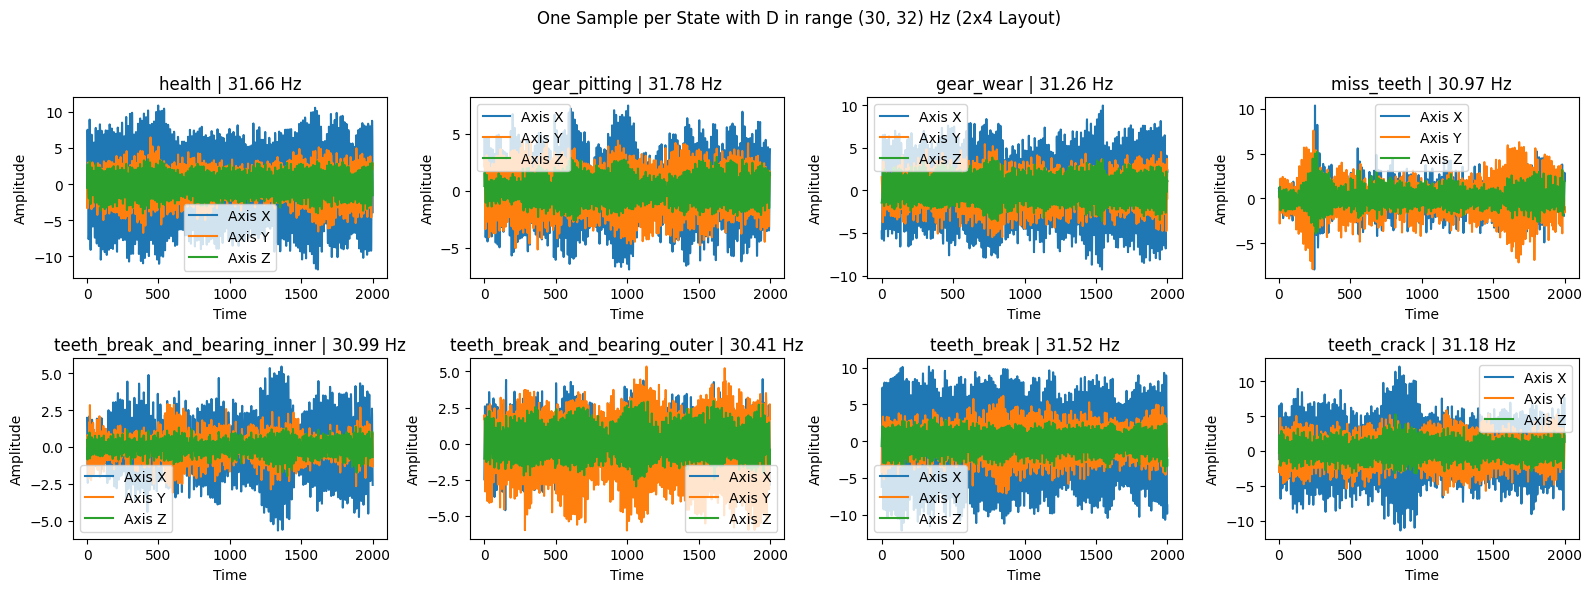

In [9]:

# Filter data within the range
filtered_indices = np.where(mask)[0]
filtered_X = X_data[filtered_indices]
filtered_Y = Y_data[filtered_indices]
filtered_D = D_data[filtered_indices]

# Initialize a list to store one sample index for each state (0 to 7)
selected_indices_per_state = []

for state in range(8):  # 0 to 7 (matching state_list)
    state_indices = np.where(filtered_Y == state)[0]
    if len(state_indices) > 0:
        # Randomly select one index for each state
        selected_indices_per_state.append(np.random.choice(state_indices, 1)[0])

# Ensure we have exactly 8 samples (one for each state)
if len(selected_indices_per_state) < 8:
    print("Not enough samples for each state in the specified range.")

# Plotting in a 2x4 layout (2 rows, 4 columns)
fig, axs = plt.subplots(2, 4, figsize=(16, 6))
fig.suptitle(f'One Sample per State with D in range {D_range} Hz (2x4 Layout)')

for i, idx in enumerate(selected_indices_per_state):
    row = i // 4
    col = i % 4
    axs[row, col].plot(filtered_X[idx, 0, :], label='Axis X')
    axs[row, col].plot(filtered_X[idx, 1, :], label='Axis Y')
    axs[row, col].plot(filtered_X[idx, 2, :], label='Axis Z')
    axs[row, col].set_title(f'{state_list[filtered_Y[idx]]} | {filtered_D[idx]:.2f} Hz')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Amplitude')
    axs[row, col].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



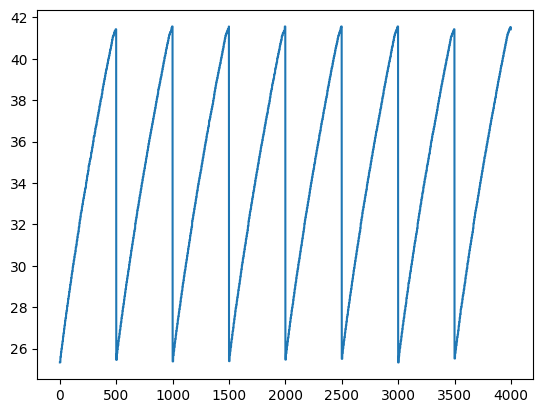

In [14]:
# 속도 분포포
plt.plot(D_data)
plt.show()

### Task

In [105]:
# import
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import argparse
from transformer.Layers import EncoderLayer

In [92]:
# 속도 분포에 따른 데이터 분류 40Hz 이상을 테스트 데이터로 설정

# Defining the threshold for speed (frequency) to separate train and test data
threshold_frequency = 40  # Hz

# Creating masks for training and test data based on the threshold
train_mask = D_data < threshold_frequency
test_mask = D_data >= threshold_frequency

# Filtering the data using the masks
X_train = X_data[train_mask]
Y_train = Y_data[train_mask]
D_train = D_data[train_mask]

X_test = X_data[test_mask]
Y_test = Y_data[test_mask]
D_test = D_data[test_mask]

# Displaying the shape of the filtered train and test sets
(X_train.shape, Y_train.shape, D_train.shape), (X_test.shape, Y_test.shape, D_test.shape)

(((3428, 3, 2000), (3428,), (3428,)), ((572, 3, 2000), (572,), (572,)))

In [91]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [93]:
parser = argparse.ArgumentParser()

# 필요시 추가 (되도록이면 자주 사용되고 바꿀 파라미터들은 여기서 관리하세용)
# 파라미터 접근 방법 opt.lr -> 1e-4가 불러와짐
parser.add_argument('--epochs',type=int, default=30, help='epoch')
parser.add_argument('--lr',type=float, default=1e-4, help='learning rate')

parser.add_argument('--lamda',type=float, default=0.97, help='schedular Lamda')
parser.add_argument('--early_stop',type=int, default=20, help='early stop_patience')

parser.add_argument('--train_size',type=float, default=0.8, help='data split/valid_size=1-x')
parser.add_argument('--batch_size',type=int, default=16, help='batch size')

opt = parser.parse_args('')

In [94]:

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=opt.train_size, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()  # Shape: (N, 3, 2000)
Y_train_tensor = torch.from_numpy(Y_train).long()   # Shape: (N,)

X_valid_tensor = torch.from_numpy(X_valid).float()
Y_valid_tensor = torch.from_numpy(Y_valid).long()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).long()

# Defining the custom dataset class
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix]
        return x.to(device).float(), y.to(device).long()

# Creating Dataset instances
train_dataset = MyDataset(X_train_tensor, Y_train_tensor)
valid_dataset = MyDataset(X_valid_tensor, Y_valid_tensor)
test_dataset = MyDataset(X_test_tensor, Y_test_tensor)

# Creating DataLoader instances
train_dl = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=opt.batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=opt.batch_size, shuffle=False)


In [113]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return x

# torch Transformer 기반 분류 모델
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=3, seq_len=2000, d_model=128, num_classes=8, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)  # (3 → d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, channels, seq_len) → (batch_size, seq_len, channels)
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)

        x = x.mean(dim=1)  # global average pooling
        return self.classifier(x)

# github Transformer 기반 분류 모델
class GitTransformerClassifier(nn.Module):
    def __init__(self, input_dim=3, seq_len=2000, d_model=128, d_inner=256, d_k=32, d_v=32, num_classes=8, n_head=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)  # (3 → d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)

        self.layers = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, channels, seq_len) → (batch_size, seq_len, channels)
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)
        x = self.pos_encoder(x)

        for layer in self.layers:
            x, _ = layer(x)
        x = x.mean(dim=1)  # global average pooling
        return self.classifier(x)
    
model1 = TransformerClassifier(input_dim=3, num_classes=Y_train.max().item()+1).to(device)
model2 = GitTransformerClassifier(input_dim=3, num_classes=Y_train.max().item()+1).to(device)

In [88]:
import numpy as np
from sklearn.metrics import accuracy_score

In [119]:
from tqdm.notebook import tqdm
import pickle

def train(opt, train_dl, valid_dl):
    
    dict_result = {'train_loss': [],
                   'valid_loss': [], 
                   'train_acc': [],
                   'valid_acc': [],
                   'stop_point': 0
                    }
    
    best_loss = 10000
    early_stopping_count = 0
    
    model = model2
    loss_cross = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(list(model.parameters()), lr=opt.lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: opt.lamda ** epoch)
    
    pbar = tqdm(range(opt.epochs), unit = 'epoch')
    
    for epoch in pbar:
        iter_loss = []
        iter_valid_loss = []
        all_preds = []
        all_targets = []
        
        # Training Model
        model.train()
        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            pred = model(x)
            loss_y = loss_cross(pred, y)

            batch_loss = loss_y
            
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            iter_loss.append(batch_loss.item())
            
            preds = torch.argmax(pred, dim=1).detach().cpu().numpy()
            targets = y.detach().cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets)
            
            pbar.set_postfix({'train_loss' : loss_y.item()})

        scheduler.step()
        train_acc = accuracy_score(all_targets, all_preds) * 100
        epoch_train_loss = np.mean(iter_loss)
        
        # Validation
        model.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            
            for ix, batch in enumerate(iter(valid_dl)):
                v_x, v_y = batch
                v_pred = model(v_x)
                v_loss_y = loss_cross(v_pred, v_y)
                
                iter_valid_loss.append(v_loss_y.item())
                
                pred_label = torch.argmax(v_pred, dim=1).cpu().numpy()
                val_preds.extend(pred_label)
                val_targets.extend(v_y.cpu().numpy())

        valid_acc = accuracy_score(val_targets, val_preds) * 100
        epoch_valid_loss = np.mean(iter_valid_loss)
       
        # pbar.set_postfix({
        #     'train_loss': epoch_train_loss,
        #     'train_acc': f'{train_acc:.3f}',
        #     'valid_loss': epoch_valid_loss,
        #     'valid_acc': f'{valid_acc:.3f}'
        # })  
        
        print(f"Epoch {epoch+1:2d} | train_loss: {epoch_train_loss:.4f}, acc: {train_acc:.3f} | "
              f"valid_loss: {epoch_valid_loss:.4f}, acc: {valid_acc:.3f}")
        
        ##################### result_save ############################           
        dict_result['train_loss'].append(epoch_train_loss)
        dict_result['valid_loss'].append(epoch_valid_loss)
        dict_result['train_acc'].append(train_acc)
        dict_result['valid_acc'].append(valid_acc)
        ###############################################################
            
        if epoch_valid_loss < best_loss:
            best_model = model
            early_stopping_count = 0
            dict_result['stop_point'] = epoch+1
            
            torch.save(model.state_dict(), 'best_model.pth')
            print( ' >>> Best model save ! '.format(epoch+1, epoch_valid_loss))

            
            best_loss = epoch_valid_loss

        else:
            early_stopping_count = early_stopping_count + 1

        if early_stopping_count > opt.early_stop:
            break
        
    return best_model
            

In [120]:
def result(test_dl, model):
    
    pred = []
    y = []
    total = 0
    
    model.eval()
    with torch.no_grad():
        for ix, batch in enumerate(iter(test_dl)):
            t_x, t_y = batch
            t_pred = model(t_x)

            pred.extend(torch.argmax(t_pred, 1).cpu().numpy())
            y.extend(t_y.cpu().numpy())
            
            total = total + len(batch[0])
            
    pred = np.array(pred)
    y = np.array(y)
    
    acc = sum(pred==y) / total * 100
    
    return acc

## ✅ Git TransformerClassifier

In [115]:
model_git = train(opt, train_dl, valid_dl)

  0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch  1 | train_loss: 2.0772, acc: 12.409 | valid_loss: 2.0627, acc: 14.692
 >>> Best model save ! 
Epoch  2 | train_loss: 2.0393, acc: 21.606 | valid_loss: 2.0249, acc: 27.160
 >>> Best model save ! 
Epoch  3 | train_loss: 1.9752, acc: 27.737 | valid_loss: 1.9616, acc: 26.795
 >>> Best model save ! 
Epoch  4 | train_loss: 1.8730, acc: 35.328 | valid_loss: 1.8352, acc: 37.404
 >>> Best model save ! 
Epoch  5 | train_loss: 1.7394, acc: 41.898 | valid_loss: 1.7081, acc: 42.472
 >>> Best model save ! 
Epoch  6 | train_loss: 1.6105, acc: 47.299 | valid_loss: 1.5757, acc: 47.357
 >>> Best model save ! 
Epoch  7 | train_loss: 1.4864, acc: 49.489 | valid_loss: 1.4634, acc: 51.440
 >>> Best model save ! 
Epoch  8 | train_loss: 1.3716, acc: 54.599 | valid_loss: 1.3824, acc: 53.664
 >>> Best model save ! 
Epoch  9 | train_loss: 1.3011, acc: 55.474 | valid_loss: 1.3198, acc: 53.117
 >>> Best model save ! 
Epoch 10 | train_loss: 1.2422, acc: 55.620 | valid_loss: 1.2654, acc: 53.627
 >>> Best mode

In [118]:
acc = result(test_dl, model_git)

print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 51.92%


## ✅ torch TransformerClassifier

In [98]:
model = train(opt, train_dl, valid_dl)

  0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch  1 | train_loss: 2.0714, acc: 13.139 | valid_loss: 2.0500, acc: 17.317
 >>> Best model save ! 
Epoch  2 | train_loss: 2.0020, acc: 25.255 | valid_loss: 1.9493, acc: 25.884
 >>> Best model save ! 
Epoch  3 | train_loss: 1.8449, acc: 35.328 | valid_loss: 1.7525, acc: 37.659
 >>> Best model save ! 
Epoch  4 | train_loss: 1.6275, acc: 44.380 | valid_loss: 1.5624, acc: 46.008
 >>> Best model save ! 
Epoch  5 | train_loss: 1.4719, acc: 49.927 | valid_loss: 1.4392, acc: 48.451
 >>> Best model save ! 
Epoch  6 | train_loss: 1.3722, acc: 51.825 | valid_loss: 1.3376, acc: 52.570
 >>> Best model save ! 
Epoch  7 | train_loss: 1.2614, acc: 55.766 | valid_loss: 1.2986, acc: 54.174
 >>> Best model save ! 
Epoch  8 | train_loss: 1.2043, acc: 56.934 | valid_loss: 1.1860, acc: 56.398
 >>> Best model save ! 
Epoch  9 | train_loss: 1.1197, acc: 62.628 | valid_loss: 1.2169, acc: 54.247
Epoch 10 | train_loss: 1.0673, acc: 62.190 | valid_loss: 1.0617, acc: 63.252
 >>> Best model save ! 
Epoch 11 | tra

In [100]:
acc = result(test_dl, model)

print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 62.59%


In [21]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(nn.Conv1d(3, 64, kernel_size=3, stride=1, padding=1),
                                     nn.BatchNorm1d(64),
                                     nn.ReLU(),
                                     nn.MaxPool1d(2, stride=2, padding =0),
                                     nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
                                     nn.BatchNorm1d(128),
                                     nn.ReLU(),
                                     nn.MaxPool1d(2, stride=2, padding =0),
                                     nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
                                     nn.BatchNorm1d(256),
                                     nn.ReLU(),
                                     nn.AdaptiveAvgPool1d(1),
                                     nn.Flatten()
                                    )

        self.predictor = nn.Sequential(
                                     nn.Linear(256, 64),
                                     nn.BatchNorm1d(64),
                                     nn.ReLU(),
                                     nn.Linear(64, 8)
                                    )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.predictor(x)
        return x
    
model = Model().to(device)

In [62]:
from tqdm.notebook import tqdm
import pickle

def train(opt, train_dl, valid_dl):
    
    dict_result = {'train_loss': [],
                   'valid_loss': [],
                   'stop_point': 0
                    }
    
    best_loss = 10000
    early_stopping_count = 0
    
    model = Model().to(device)
    loss_cross = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(list(model.parameters()), lr=opt.lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: opt.lamda ** epoch)
    
    pbar = tqdm(range(opt.epochs), unit = 'epoch')
    
    for epoch in pbar:
        iter_loss = []
        iter_valid_loss = []
        
        # Training Model
        model.train()
        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            pred = model(x)
            loss_y = loss_cross(pred, y)

            batch_loss = loss_y
            
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            iter_loss.append(batch_loss.item())
            
            pbar.set_postfix({'train_loss' : loss_y.item()})

        scheduler.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            
            for ix, batch in enumerate(iter(valid_dl)):
                v_x, v_y = batch
                v_pred = model(v_x)
                v_loss_y = loss_cross(v_pred, v_y)
                
                iter_valid_loss.append(v_loss_y.item())

        epoch_train = np.mean(iter_loss)
        epoch_valid = np.mean(iter_valid_loss)

        print( ' Epoch: {} / train_loss: {:.4f} / valid_loss: {:.4f}'.format(epoch+1, epoch_train, epoch_valid))
            
        ##################### result_save ############################           
        dict_result['train_loss'].append(epoch_train)
        dict_result['valid_loss'].append(epoch_valid)
        ###############################################################
            
        if epoch_valid < best_loss:
            best_model = model
            early_stopping_count = 0
            dict_result['stop_point'] = epoch+1
            print( ' >>> Best model save ! '.format(epoch+1, epoch_valid))
            
            best_loss = epoch_valid

        else:
            early_stopping_count = early_stopping_count + 1

        if early_stopping_count > opt.early_stop:
            break
        
    return best_model
            

In [63]:
model = train(opt, train_dl, valid_dl)

  0%|          | 0/50 [00:00<?, ?epoch/s]

 Epoch: 1 / train_loss: 1.6905 / valid_loss: 1.4759
 >>> Best model save ! 
 Epoch: 2 / train_loss: 1.3612 / valid_loss: 1.2653
 >>> Best model save ! 
 Epoch: 3 / train_loss: 1.2019 / valid_loss: 1.0908
 >>> Best model save ! 
 Epoch: 4 / train_loss: 1.0854 / valid_loss: 0.9593
 >>> Best model save ! 
 Epoch: 5 / train_loss: 0.9901 / valid_loss: 0.9184
 >>> Best model save ! 
 Epoch: 6 / train_loss: 0.8736 / valid_loss: 0.7733
 >>> Best model save ! 
 Epoch: 7 / train_loss: 0.8066 / valid_loss: 0.7142
 >>> Best model save ! 
 Epoch: 8 / train_loss: 0.7321 / valid_loss: 0.6591
 >>> Best model save ! 
 Epoch: 9 / train_loss: 0.6684 / valid_loss: 0.6157
 >>> Best model save ! 
 Epoch: 10 / train_loss: 0.6129 / valid_loss: 0.5252
 >>> Best model save ! 
 Epoch: 11 / train_loss: 0.5684 / valid_loss: 0.5157
 >>> Best model save ! 
 Epoch: 12 / train_loss: 0.5348 / valid_loss: 0.5241
 Epoch: 13 / train_loss: 0.4833 / valid_loss: 0.4253
 >>> Best model save ! 
 Epoch: 14 / train_loss: 0.4525 

In [64]:
def result(test_dl, model):
    
    pred = []
    y = []
    total = 0
    
    model.eval()
    with torch.no_grad():
        for ix, batch in enumerate(iter(test_dl)):
            t_x, t_y = batch
            t_pred = model(t_x)

            pred.extend(torch.argmax(t_pred, 1).cpu().numpy())
            y.extend(t_y.cpu().numpy())
            
            total = total + len(batch[0])
            
    pred = np.array(pred)
    y = np.array(y)
    
    acc = sum(pred==y) / total * 100
    
    return acc

In [65]:
acc = result(test_dl, model)

print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 63.64%
